In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

2024-11-07 14:19:06.009348: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 14:19:10.577302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730985552.047530   20958 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730985552.441556   20958 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 14:19:16.656484: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Def various functions for labels transformation and common sense error

In [2]:
def periodic_trans(time):
    time_period = np.round([np.cos(time[:,0]/12*2*np.pi),
                            np.sin(time[:,0]/12*2*np.pi),
                            np.cos(time[:,1]/60*2*np.pi),
                            np.sin(time[:,1]/60*2*np.pi)],5)
    return time_period.T

def period_to_hrmin(period_time,hr_or_min):
    # convert period to clk time (either hr or min, for hr use 12, for min use 60 for hr_or_min)
    time_y_rad = np.arctan2(period_time[:,1],period_time[:,0])
    time_y = (time_y_rad < 0)*2*np.pi + time_y_rad
    time_clk = time_y/2/np.pi*hr_or_min
    return np.round(time_clk)

def period_to_clk(period_time):
    return np.array([period_to_hrmin(period_time[:,:2],12),
                     period_to_hrmin(period_time[:,2:],60)]).T

# ty1 = period_to_clk(train_ty_period)
# test_ty_period = periodic_trans(test_ty)

def calculate_angle(vec1, vec2):
    dot_product = np.sum(vec1 * vec2, axis=1)
    mag1 = np.linalg.norm(vec1, axis=1)
    mag2 = np.linalg.norm(vec2, axis=1)
    cos_theta = dot_product / (mag1 * mag2)
    angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip to avoid domain errors
    return angle

def common_sense_err(test_y,pred_y):
    hr_angle = calculate_angle(test_y[:,:2],pred_y[:,:2])
    min_angle = calculate_angle(test_y[:,2:],pred_y[:,2:])
    hr_diff = hr_angle/2/np.pi*12
    min_diff = min_angle/2/np.pi*60
    return np.round(np.array([hr_diff,min_diff]).T)

def single_angle_trans(clk_time):
    time_rad = clk_time[:,0]/12*2*np.pi + clk_time[:,1]/60*np.pi/6
    time_per = np.array(np.round([np.cos(time_rad),
                                  np.sin(time_rad)],5)).T
    return time_per

def s_ang_to_clk(s_angle):
    y_rad = np.arctan2(s_angle[:,1],s_angle[:,0])
    y_rad2 = (y_rad < 0)*2*np.pi + y_rad
    y_clk = y_rad2/2/np.pi*12
    return np.array([y_clk.astype(int),np.round(y_clk%1*60)]).T

def common_sense_err2(test_y,pred_y):
    sa1 = single_angle_trans(pred_y)
    sa2 = single_angle_trans(test_y)
    sa_diff = calculate_angle(sa1,sa2)
    hr_diff = sa_diff//(np.pi/6)
    min_diff = np.round((sa_diff%(np.pi/6)*6*60/np.pi))
    return np.array([hr_diff,min_diff]).T

# train_ty_period = periodic_trans(train_ty)
# print(train_ty_period[:10])
# train_ty_period[:,2:]

# y1 = period_to_hrmin(train_ty_period[:,2:],60)
# tt1 = test_ty_period[:3]
# tt2 = train_ty_period[:3]
# train_ty[:10]
# calculate_angle(tt1[:,:2],tt2[:,:2])
# print(common_sense_err(tt1,tt2))

# tt3 = single_angle_trans(train_ty[:3])
# tt4 = single_angle_trans(test_ty[:3])
# sa1 = calculate_angle(tt3,tt4)

# common_sense_err2(train_ty[:3],test_ty[:3])

Importing Data

In [ ]:
train_ty[:10],test_ty[:10]
train_ty_period = periodic_trans(train_ty)
test_ty_period = periodic_trans(test_ty)
train_ty_period[:,2:]


array([[-0.97815,  0.20791],
       [-0.91355, -0.40674],
       [ 0.97815, -0.20791],
       ...,
       [-0.86603, -0.5    ],
       [-0.91355, -0.40674],
       [-0.99452, -0.10453]])

In [ ]:
time_x = np.load('s_images.npy')
time_y = np.load('s_labels.npy')
train_tx, test_tx, train_ty, test_ty = train_test_split(time_x, time_y, test_size=0.1, random_state=42)

In [ ]:
train_tx[:,1]
train_ty

Model Type 5.1: Multi-head with scaled regression

In [ ]:
K.clear_session()


input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(1,name='min_y')(min_y)

model_time_MH1 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH1.summary()
print(model_time_MH1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH1.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH1 = model_time_MH1.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty[:,1]/59},
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping, reduce_lr])

I0000 00:00:1730573436.054085 2058174 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6180 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 877,997 (3.35 MB)

 Trainable params: 877,549 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30


I0000 00:00:1730573437.996184 2212044 service.cc:148] XLA service 0x723a2c005060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730573437.996207 2212044 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-02 19:50:38.039776: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730573438.193969 2212044 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-02 19:50:38.328884: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-02 19:50:3

  4/146 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - hr_y_accuracy: 0.1000 - hr_y_loss: 3.1773 - loss: 15.6214 - min_y_loss: 5.9080 - min_y_mae: 2.0126

I0000 00:00:1730573442.429080 2212044 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/146 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - hr_y_accuracy: 0.0818 - hr_y_loss: 2.5908 - loss: 8.5860 - min_y_loss: 0.7959 - min_y_mae: 0.5267

2024-11-02 19:50:46.795745: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 40 bytes spill stores, 40 bytes spill loads

2024-11-02 19:50:46.874486: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 4 bytes spill stores, 4 bytes spill loads

2024-11-02 19:50:46.885516: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 276 bytes spill stores, 276 bytes spill loads

2024-11-02 19:50:47.028160: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1777', 12 bytes spill stores, 12 bytes spill loads

2024-11-02 19:50:47.047806: I external/local_xla/xla/stream_executor/

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - hr_y_accuracy: 0.0818 - hr_y_loss: 2.5902 - loss: 8.5717 - min_y_loss: 0.7915 - min_y_mae: 0.5252

2024-11-02 19:50:51.298533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 60 bytes spill stores, 60 bytes spill loads

2024-11-02 19:50:51.388389: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 40 bytes spill stores, 40 bytes spill loads

2024-11-02 19:50:51.439326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 572 bytes spill stores, 504 bytes spill loads



146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - hr_y_accuracy: 0.0818 - hr_y_loss: 2.5899 - loss: 8.5647 - min_y_loss: 0.7893 - min_y_mae: 0.5244 - val_hr_y_accuracy: 0.0833 - val_hr_y_loss: 2.4855 - val_loss: 5.1098 - val_min_y_loss: 0.1337 - val_min_y_mae: 0.3018 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0801 - hr_y_loss: 2.4866 - loss: 4.7005 - min_y_loss: 0.0966 - min_y_mae: 0.2622 - val_hr_y_accuracy: 0.0914 - val_hr_y_loss: 2.4842 - val_loss: 3.9736 - val_min_y_loss: 0.1244 - val_min_y_mae: 0.2925 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0916 - hr_y_loss: 2.4866 - loss: 3.7836 - min_y_loss: 0.0852 - min_y_mae: 0.2406 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4864 - val_loss: 3.5053 - val_min_y_loss: 0.1478 - val_min_y_mae: 0.3137 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.1081 - hr_y_loss: 2.4563 - loss: 3.3297 - min_y

2024-11-02 19:53:10.467298: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 244 bytes spill stores, 244 bytes spill loads

2024-11-02 19:53:10.505423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 40 bytes spill stores, 40 bytes spill loads

2024-11-02 19:53:10.554941: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 540 bytes spill stores, 604 bytes spill loads

2024-11-02 19:53:11.559538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 248 bytes spill stores, 272 bytes spill loads



57/57 - 2s - 34ms/step - hr_y_accuracy: 0.8756 - hr_y_loss: 0.3335 - loss: 0.5920 - min_y_loss: 0.0295 - min_y_mae: 0.1110


[0.5920030474662781,
 0.3334738314151764,
 0.02953070029616356,
 0.8755555748939514,
 0.11101049929857254]

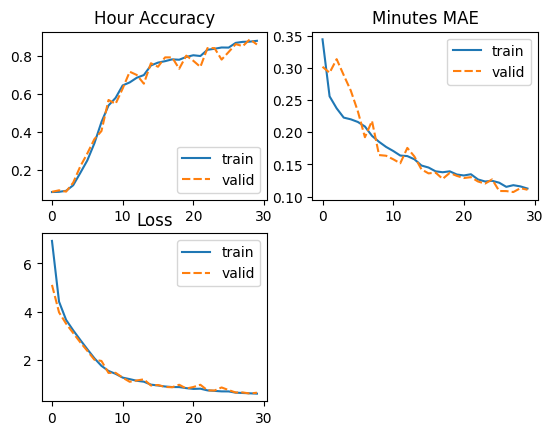

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH1.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH1.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH1.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH1.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH1.history['loss']
loss_df['valid'] = his_model_time_MH1.history['val_loss']
fig, axs = plt.subplots(ncols=2,nrows=2)
sns.lineplot(hr_acc_df,ax=axs[0,0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[0,1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[1,0]).set_title("Loss")
axs[1, 1].axis('off')
model_time_MH1.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y': test_ty[:, 1] / 59}, verbose=2)

In [ ]:
print(test_ty[0:10])
pred_hr_MH1,pred_min_MH1 = model_time_MH1.predict(test_tx)
hr_MH1 = np.argmax(tf.nn.softmax(pred_hr_MH1),axis=1)
min_MH1 = np.round(pred_min_MH1*60).flatten()
hr_MH1[:10],min_MH1[:10]
pred_MH1 = np.array([hr_MH1,min_MH1]).T
pred_MH1
np.mean(common_sense_err2(test_ty,pred_MH1),axis = 0)

[[ 1 42]
 [ 4 59]
 [ 6  8]
 [ 3 38]
 [ 0 29]
 [ 7 50]
 [ 0 34]
 [ 4 50]
 [ 7 39]
 [ 7 44]]
 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([0.035     , 9.48222222])

Multi-head with periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2 = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2.summary()
print(model_time_MH2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2 = model_time_MH2.fit(train_tx, {'hr_y': train_ty[:,0], 'min_y': train_ty_period[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 75, 75, 1) │          0 │ input_layer[0][0] │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 73, 73,    │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 73, 73,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 34, 34,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 878,062 (3.35 MB)

 Trainable params: 877,614 (3.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - hr_y_accuracy: 0.0833 - hr_y_loss: 2.5754 - loss: 8.3791 - min_y_loss: 0.8390 - min_y_mae: 0.7411 - val_hr_y_accuracy: 0.0877 - val_hr_y_loss: 2.4958 - val_loss: 4.7100 - val_min_y_loss: 0.5162 - val_min_y_mae: 0.6445 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accuracy: 0.0817 - hr_y_loss: 2.4860 - loss: 4.2906 - min_y_loss: 0.4728 - min_y_mae: 0.6118 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4854 - val_loss: 3.6739 - val_min_y_loss: 0.4856 - val_min_y_mae: 0.6280 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - hr_y_accuracy: 0.0835 - hr_y_loss: 2.4815 - loss: 3.4261 - min_y_loss: 0.3364 - min_y_mae: 0.4896 - val_hr_y_accuracy: 0.0784 - val_hr_y_loss: 2.4751 - val_loss: 3.3191 - val_min_y_loss: 0.4441 - val_min_y_mae: 0.5905 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - hr_y_accurac

57/57 - 1s - 18ms/step - hr_y_accuracy: 0.8661 - hr_y_loss: 0.3652 - loss: 0.6457 - min_y_loss: 0.0429 - min_y_mae: 0.1492


[0.6457475423812866,
 0.3652147650718689,
 0.042850155383348465,
 0.8661110997200012,
 0.1491561383008957]

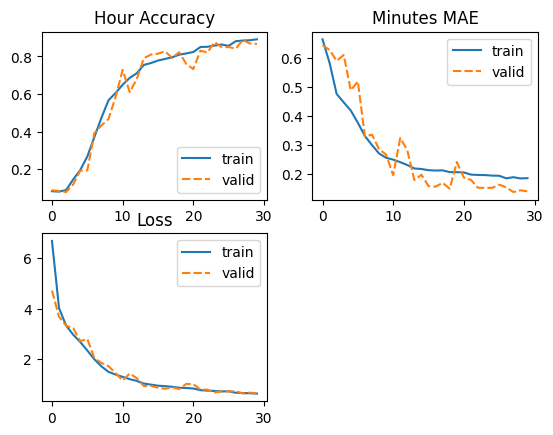

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2.history['loss']
loss_df['valid'] = his_model_time_MH2.history['val_loss']
fig, axs = plt.subplots(ncols=2,nrows=2)
sns.lineplot(hr_acc_df,ax=axs[0,0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[0,1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[1,0]).set_title("Loss")
axs[1, 1].axis('off')
model_time_MH2.evaluate(test_tx,  {'hr_y': test_ty[:, 0], 'min_y':test_ty_period[:,2:] }, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_hr_MH2,pred_min_MH2 = model_time_MH2.predict(test_tx)
pred_hr_MH2[:10],pred_min_MH2[:10]
hr_MH2 = np.argmax(tf.nn.softmax(pred_hr_MH2),axis=1)
min_MH2 = period_to_hrmin(pred_min_MH2,60)
hr_MH2[:10],min_MH2[:10]
pred_MH2 = np.array([hr_MH2,min_MH2]).T
print(test_ty[:3],pred_MH2[:3])
np.mean(common_sense_err2(test_ty,pred_MH2),axis = 0)

 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 44.]
 [ 5. 57.]
 [ 6.  7.]]


array([0.05722222, 6.29333333])

Single Angle Periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1.summary()
print(model_time_P1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1 = model_time_P1.fit(train_tx, single_angle_trans(train_ty),
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 3.3799 - mae: 0.7203 - val_loss: 1.6087 - val_mae: 0.6349 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3679 - mae: 0.6097 - val_loss: 0.9730 - val_mae: 0.6195 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7306 - mae: 0.4609 - val_loss: 0.6978 - val_mae: 0.5807 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4706 - mae: 0.3883 - val_loss: 0.5480 - val_mae: 0.5379 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3223 - mae: 0.3223 - val_loss: 0.3491 - val_mae: 0.4061 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2355 - mae: 0.2772 - val_loss: 0.2506 - val_mae: 0.3248 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1872 - mae: 0.2522 - val_loss: 0.2538 

57/57 - 0s - 2ms/step - loss: 0.0467 - mae: 0.1276


[0.04665307328104973, 0.1276242434978485]

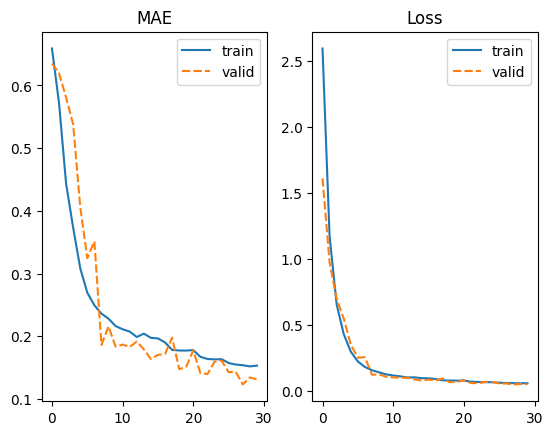

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1.history['mae']
mae_df['valid'] = his_model_time_P1.history['val_mae']
loss_df['train'] = his_model_time_P1.history['loss']
loss_df['valid'] = his_model_time_P1.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1.evaluate(test_tx,  single_angle_trans(test_ty), verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_P1 = model_time_P1.predict(test_tx)
pred_P1 = s_ang_to_clk(pred_y_P1)
print(test_ty[:3],pred_P1[:3])
np.mean(common_sense_err2(test_ty,pred_P1),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 37.]
 [ 5. 15.]
 [ 6. 28.]]


array([1.38888889e-02, 1.58538889e+01])

Periodic transformation

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2.summary()
print(model_time_P2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2 = model_time_P2.fit(train_tx, train_ty_period,
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,620 (1.78 MB)

 Trainable params: 467,172 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 3.5610 - mae: 0.7521 - val_loss: 1.7831 - val_mae: 0.6379 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.5359 - mae: 0.6108 - val_loss: 1.0925 - val_mae: 0.6228 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8784 - mae: 0.5101 - val_loss: 0.7708 - val_mae: 0.5942 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.6161 - mae: 0.4826 - val_loss: 0.5538 - val_mae: 0.5288 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4925 - mae: 0.4736 - val_loss: 0.4305 - val_mae: 0.4770 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4212 - mae: 0.4628 - val_loss: 0.4144 - val_mae: 0.4959 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3824 - mae: 0.4579 - val_loss: 0.3447 

57/57 - 1s - 12ms/step - loss: 0.0890 - mae: 0.1881


[0.08903136104345322, 0.18809112906455994]

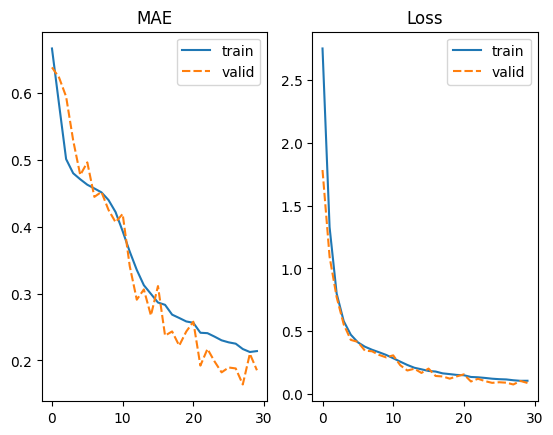

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2.history['mae']
mae_df['valid'] = his_model_time_P2.history['val_mae']
loss_df['train'] = his_model_time_P2.history['loss']
loss_df['valid'] = his_model_time_P2.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2.evaluate(test_tx,  test_ty_period, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_P2 = model_time_P2.predict(test_tx)
pred_P2 = period_to_clk(pred_y_P2)
print(test_ty[:3],pred_P2[:3])
np.mean(common_sense_err2(test_ty,pred_P2),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[11. 45.]
 [ 5.  1.]
 [ 6.  5.]]


array([ 0.13166667, 12.73888889])

Dual Regression, scaled

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR1 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR1.summary()
print(model_time_DR1)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR1.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
train_ty2 = np.array([train_ty[:,0]/11,train_ty[:,1]/59]).T
his_model_time_DR1 = model_time_DR1.fit(train_tx, train_ty2,
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 3.5087 - mae: 0.4733 - val_loss: 1.6523 - val_mae: 0.3453 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3704 - mae: 0.2716 - val_loss: 1.0347 - val_mae: 0.3950 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8015 - mae: 0.2497 - val_loss: 0.7087 - val_mae: 0.3778 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5319 - mae: 0.2351 - val_loss: 0.4614 - val_mae: 0.2929 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3826 - mae: 0.2307 - val_loss: 0.3149 - val_mae: 0.2334 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2901 - mae: 0.2259 - val_loss: 0.2381 - val_mae: 0.2155 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2302 - mae: 0.2220 - val_loss: 0.1917 

57/57 - 1s - 9ms/step - loss: 0.0709 - mae: 0.2064


[0.0708974152803421, 0.20641261339187622]

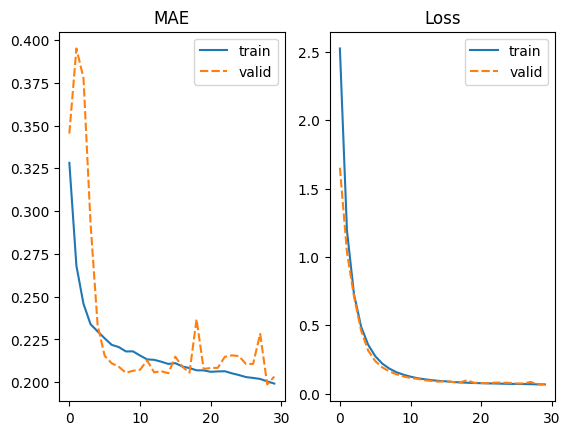

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR1.history['mae']
mae_df['valid'] = his_model_time_DR1.history['val_mae']
loss_df['train'] = his_model_time_DR1.history['loss']
loss_df['valid'] = his_model_time_DR1.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
test_ty2 = np.array([test_ty[:,0]/11,test_ty[:,1]/59]).T
model_time_DR1.evaluate(test_tx,  test_ty2, verbose=2)

In [ ]:
# print(test_ty[0:10])
pred_y_DR1 = model_time_DR1.predict(test_tx)
pred_DR1 = np.round(np.array([pred_y_DR1[:,0]*11,pred_y_DR1[:,1]*59]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR1[:3])
np.mean(common_sense_err2(test_ty,pred_DR1),axis = 0)
#array([ 1.41444444, 27.49444444])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 4. 24.]
 [ 6. 30.]
 [ 5. 30.]]


array([ 1.58777778, 33.175     ])

Non scaled Dual regression

In [ ]:
K.clear_session()

input_layer = tf.keras.Input(shape=(75,75,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_DR2 = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_DR2.summary()
print(model_time_DR2)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_DR2.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])
his_model_time_DR2 = model_time_DR2.fit(train_tx, train_ty,
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 34, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 467,490 (1.78 MB)

 Trainable params: 467,042 (1.78 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 191.5257 - mae: 9.7867 - val_loss: 627.8676 - val_mae: 18.6968 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 141.8949 - mae: 8.1075 - val_loss: 557.7598 - val_mae: 17.4015 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 126.5879 - mae: 7.5487 - val_loss: 354.9451 - val_mae: 13.3224 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 117.7915 - mae: 7.2269 - val_loss: 220.6313 - val_mae: 10.1665 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 108.7561 - mae: 6.9285 - val_loss: 157.1507 - val_mae: 8.3988 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 98.5220 - mae: 6.5732 - val_loss: 94.4612 - val_mae: 6.3011 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 91.9467 - mae:

57/57 - 1s - 22ms/step - loss: 42.6542 - mae: 3.6073


[42.65418243408203, 3.6072628498077393]

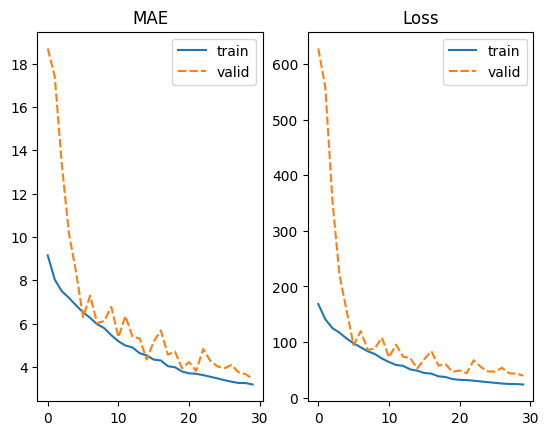

In [ ]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_DR2.history['mae']
mae_df['valid'] = his_model_time_DR2.history['val_mae']
loss_df['train'] = his_model_time_DR2.history['loss']
loss_df['valid'] = his_model_time_DR2.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_DR2.evaluate(test_tx,  test_ty, verbose=2)

In [4]:
# print(test_ty[0:10])
pred_y_DR2 = model_time_DR2.predict(test_tx)
pred_DR2 = np.round(np.array([pred_y_DR2[:,0],pred_y_DR2[:,1]]).T)
# pred_DR1 = np.round(pred_y_DR1)
print(test_ty[:3],pred_DR2[:3])
np.mean(common_sense_err2(test_ty,pred_DR2),axis = 0)
#array([ 1.41444444, 27.49444444])

NameError: name 'model_time_DR2' is not defined

150 x 150

In [3]:
time_x_L = np.load('images.npy')
time_y_L = np.load('labels.npy')
train_tx_L, test_tx_L, train_ty_L, test_ty_L = train_test_split(time_x_L, time_y_L, test_size=0.1, random_state=42)
train_ty_period_L = periodic_trans(train_ty_L)
test_ty_period_L = periodic_trans(test_ty_L)

In [38]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 17, 17,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 18496)     │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  2,367,616 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]   

 Total params: 4,810,222 (18.35 MB)

 Trainable params: 4,809,774 (18.35 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - hr_y_accuracy: 0.0817 - hr_y_loss: 3.0470 - loss: 13.6692 - min_y_loss: 4.5876 - min_y_mae: 1.1401 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4940 - val_loss: 6.1296 - val_min_y_loss: 0.5179 - val_min_y_mae: 0.6430 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - hr_y_accuracy: 0.0851 - hr_y_loss: 2.4872 - loss: 5.6627 - min_y_loss: 0.5085 - min_y_mae: 0.6368 - val_hr_y_accuracy: 0.0784 - val_hr_y_loss: 2.4871 - val_loss: 4.7347 - val_min_y_loss: 0.4994 - val_min_y_mae: 0.6360 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - hr_y_accuracy: 0.0825 - hr_y_loss: 2.4882 - loss: 4.5600 - min_y_loss: 0.4802 - min_y_mae: 0.6169 - val_hr_y_accuracy: 0.0827 - val_hr_y_loss: 2.4850 - val_loss: 4.1779 - val_min_y_loss: 0.4590 - val_min_y_mae: 0.6073 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - hr_y

57/57 - 1s - 15ms/step - hr_y_accuracy: 0.0750 - hr_y_loss: 2.4855 - loss: 2.6527 - min_y_loss: 0.0845 - min_y_mae: 0.2375
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 39.]
 [ 0. 60.]
 [ 0.  8.]]


array([ 2.56722222, 29.79388889])

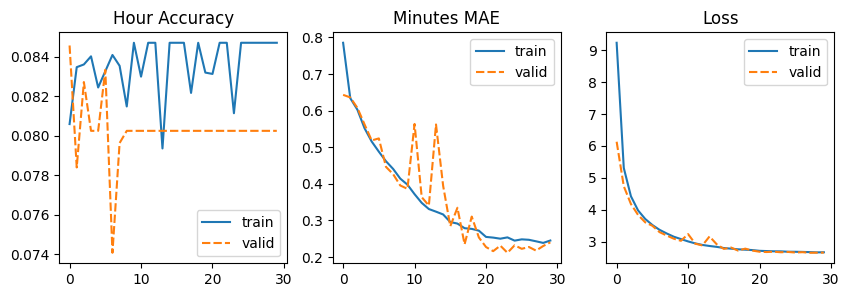

In [39]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(10,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)
# print(test_ty[0:10])
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

In [4]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)

hr_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
hr_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(hr_y)
hr_y = tf.keras.layers.Dropout(0.2)(hr_y)
hr_y = tf.keras.layers.Dense(12,name='hr_y')(hr_y)

min_y = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
min_y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(min_y)
min_y = tf.keras.layers.Dropout(0.2)(min_y)
min_y = tf.keras.layers.Dense(2,name='min_y')(min_y)

model_time_MH2_L = tf.keras.Model(inputs=input_layer, outputs=[hr_y, min_y])
model_time_MH2_L.summary()
print(model_time_MH2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_MH2_L.compile(optimizer=optimizer,
                       loss={'hr_y': loss_fn, 'min_y': 'mse'},
                       metrics={'hr_y': 'accuracy', 'min_y': 'mae'})

his_model_time_MH2_L = model_time_MH2_L.fit(train_tx_L, {'hr_y': train_ty_L[:,0], 'min_y': train_ty_period_L[:,2:]},
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

I0000 00:00:1730985681.642261   20958 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6045 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │      1,280 │ rescaling[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 148, 148,  │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     36,896 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 34, 34,    │      9,248 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 34,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 15, 15,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 7, 7, 64)  │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    401,536 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    401,536 │ flatten[0][0]   

 Total params: 887,438 (3.39 MB)

 Trainable params: 886,926 (3.38 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/30


I0000 00:00:1730985688.775989   21502 service.cc:148] XLA service 0x754628015910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730985688.777054   21502 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-07 14:21:29.262969: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730985689.916892   21502 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-07 14:21:30.258214: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-07 14:21:3

143/146 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - hr_y_accuracy: 0.0803 - hr_y_loss: 2.5697 - loss: 9.0446 - min_y_loss: 1.3806 - min_y_mae: 0.8251

2024-11-07 14:22:01.359635: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 276 bytes spill stores, 276 bytes spill loads

2024-11-07 14:22:01.410430: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 40 bytes spill stores, 40 bytes spill loads

2024-11-07 14:22:01.511542: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2053', 32 bytes spill stores, 32 bytes spill loads

2024-11-07 14:22:01.731035: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 2184 bytes spill stores, 1704 bytes spill loads

2024-11-07 14:22:01.744917: I external/local_xla/xla/stream_executor/

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - hr_y_accuracy: 0.0802 - hr_y_loss: 2.5695 - loss: 9.0362 - min_y_loss: 1.3776 - min_y_mae: 0.8244

2024-11-07 14:22:10.779302: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 40 bytes spill stores, 40 bytes spill loads

2024-11-07 14:22:10.879400: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 60 bytes spill stores, 60 bytes spill loads

2024-11-07 14:22:10.884605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 572 bytes spill stores, 504 bytes spill loads



146/146 ━━━━━━━━━━━━━━━━━━━━ 45s 174ms/step - hr_y_accuracy: 0.0802 - hr_y_loss: 2.5692 - loss: 9.0278 - min_y_loss: 1.3747 - min_y_mae: 0.8238 - val_hr_y_accuracy: 0.0784 - val_hr_y_loss: 2.4871 - val_loss: 5.3997 - val_min_y_loss: 0.6917 - val_min_y_mae: 0.6971 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - hr_y_accuracy: 0.0811 - hr_y_loss: 2.4831 - loss: 4.7385 - min_y_loss: 0.3897 - min_y_mae: 0.5337 - val_hr_y_accuracy: 0.0846 - val_hr_y_loss: 2.4778 - val_loss: 4.2376 - val_min_y_loss: 0.5831 - val_min_y_mae: 0.6579 - learning_rate: 0.0010
Epoch 3/30


2024-11-07 14:22:36.850133: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.40GiB (rounded to 3653841408)requested by op 
2024-11-07 14:22:36.850288: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2024-11-07 14:22:36.850309: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 1037, Chunks in use: 1037. 259.2KiB allocated for chunks. 259.2KiB in use in bin. 11.1KiB client-requested in use in bin.
2024-11-07 14:22:36.850319: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks: 23, Chunks in use: 20. 12.0KiB allocated for chunks. 10.0KiB in use in bin. 10.0KiB client-requested in use in bin.
2024-11-07 14:22:36.850328: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (1024): 	Total Chunks: 6, Chunks in use: 4. 7.0KiB allocated for chunks. 4.5KiB in use in bin. 3.4KiB client-requested

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_20958/1756602267.py", line 46, in <module>

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/vol/home/s4147510/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 3653841160 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_6213]

57/57 - 0s - 6ms/step - hr_y_accuracy: 0.0750 - hr_y_loss: 2.4855 - loss: 2.6527 - min_y_loss: 0.0845 - min_y_mae: 0.2375


[2.652722120285034,
 2.485474109649658,
 0.08454768359661102,
 0.07500000298023224,
 0.23753765225410461]

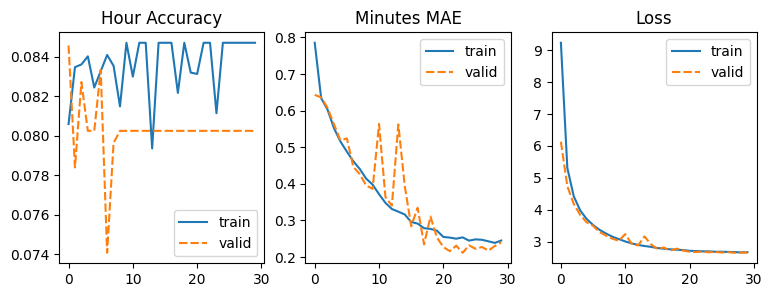

In [ ]:
hr_acc_df = pd.DataFrame()
loss_df = pd.DataFrame()
min_mae_df = pd.DataFrame()
hr_acc_df['train'] = his_model_time_MH2_L.history['hr_y_accuracy']
hr_acc_df['valid'] = his_model_time_MH2_L.history['val_hr_y_accuracy']
min_mae_df['train'] = his_model_time_MH2_L.history['min_y_mae']
min_mae_df['valid'] = his_model_time_MH2_L.history['val_min_y_mae']
loss_df['train'] = his_model_time_MH2_L.history['loss']
loss_df['valid'] = his_model_time_MH2_L.history['val_loss']
fig, axs = plt.subplots(ncols=3,nrows=1,figsize=(9,3))
# plt.figure(figsize=(6,15))
sns.lineplot(hr_acc_df,ax=axs[0]).set_title("Hour Accuracy")
sns.lineplot(min_mae_df,ax=axs[1]).set_title("Minutes MAE")
sns.lineplot(loss_df,ax=axs[2]).set_title("Loss")
# axs[1, 1].axis('off')
model_time_MH2_L.evaluate(test_tx_L,  {'hr_y': test_ty_L[:, 0], 'min_y':test_ty_period_L[:,2:] }, verbose=2)

In [35]:
# print(test_ty[0:10])
pred_hr_MH2_L,pred_min_MH2_L = model_time_MH2_L.predict(test_tx_L)
pred_hr_MH2_L[:10],pred_min_MH2_L[:10]
hr_MH2_L = np.argmax(tf.nn.softmax(pred_hr_MH2_L),axis=1)
min_MH2_L = period_to_hrmin(pred_min_MH2_L,60)
hr_MH2_L[:10],min_MH2_L[:10]
pred_MH2_L = np.array([hr_MH2_L,min_MH2_L]).T
print(test_ty_L[:3],pred_MH2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_MH2_L),axis = 0)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 0. 42.]
 [ 4. 58.]
 [ 6. 10.]]


array([0.05111111, 5.60111111])

In [41]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,570 (9.28 MB)

 Trainable params: 2,433,122 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 6.8151 - mae: 1.1519 - val_loss: 2.6856 - val_mae: 0.6369 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 2.4142 - mae: 0.6052 - val_loss: 1.8582 - val_mae: 0.6191 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.6271 - mae: 0.5171 - val_loss: 1.3740 - val_mae: 0.5758 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.2170 - mae: 0.4813 - val_loss: 1.0353 - val_mae: 0.5065 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 0.9456 - mae: 0.4456 - val_loss: 0.8180 - val_mae: 0.4585 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 0.7555 - mae: 0.4036 - val_loss: 0.9735 - val_mae: 0.6195 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 0.6297 - mae: 0.3775 - val

57/57 - 0s - 5ms/step - loss: 0.1401 - mae: 0.1992
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 29.]
 [ 5.  6.]
 [ 5. 22.]]


array([ 0.10888889, 20.91      ])

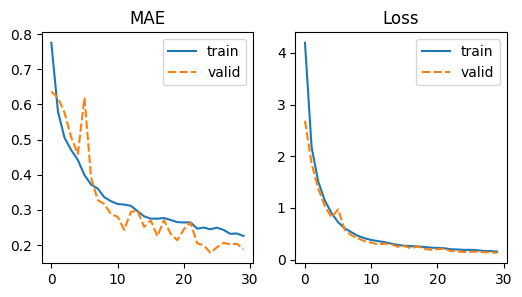

In [46]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

In [47]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(2)(x)

model_time_P1_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P1_L.summary()
print(model_time_P1_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P1_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P1_L = model_time_P1_L.fit(train_tx_L, single_angle_trans(train_ty_L),
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,866 (1.82 MB)

 Trainable params: 476,354 (1.82 MB)

 Non-trainable params: 512 (2.00 KB)

<Functional name=functional, built=True>
Epoch 1/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - loss: 4.7805 - mae: 0.8984 - val_loss: 2.5930 - val_mae: 0.6331 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 2.3391 - mae: 0.5878 - val_loss: 1.9033 - val_mae: 0.6258 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 1.6434 - mae: 0.5034 - val_loss: 1.4232 - val_mae: 0.5821 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 1.2102 - mae: 0.4440 - val_loss: 1.0534 - val_mae: 0.5002 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 0.9066 - mae: 0.3853 - val_loss: 0.7982 - val_mae: 0.4195 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 0.6931 - mae: 0.3391 - val_loss: 0.5595 - val_mae: 0.3007 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 0.5512 - mae: 0.3139 - val_loss:

57/57 - 1s - 13ms/step - loss: 0.0525 - mae: 0.1274
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 1. 22.]
 [ 5.  5.]
 [ 5. 34.]]


array([1.22222222e-02, 1.51744444e+01])

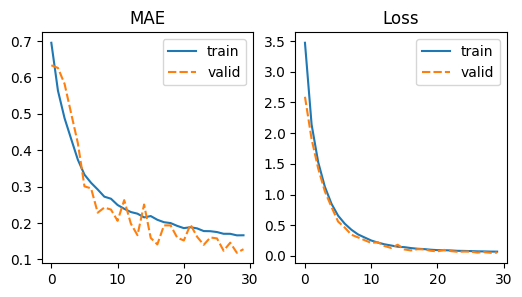

In [48]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P1_L.history['mae']
mae_df['valid'] = his_model_time_P1_L.history['val_mae']
loss_df['train'] = his_model_time_P1_L.history['loss']
loss_df['valid'] = his_model_time_P1_L.history['val_loss']
fig, axs = plt.subplots(ncols=2,figsize=(6,3))
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P1_L.evaluate(test_tx_L,  single_angle_trans(test_ty_L), verbose=2)
# print(test_ty[0:10])
pred_y_P1_L = model_time_P1_L.predict(test_tx_L)
pred_P1_L = s_ang_to_clk(pred_y_P1_L)
print(test_ty_L[:3],pred_P1_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P1_L),axis = 0)

In [4]:
K.clear_session()

input_layer = tf.keras.Input(shape=(150,150,1))
x = tf.keras.layers.Rescaling(1./255)(input_layer)
# x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
# x = tf.keras.layers.RandomRotation(0.2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(4)(x)

model_time_P2_L = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_time_P2_L.summary()
print(model_time_P2_L)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=2, min_lr=1e-6, verbose=1)

model_time_P2_L.compile(optimizer=optimizer,
                       loss= 'mse',
                       metrics=['mae'])

his_model_time_P2_L = model_time_P2_L.fit(train_tx_L, train_ty_period_L,
                                    epochs = 30, validation_split=0.1, batch_size = 100,
                                    callbacks = [early_stopping,reduce_lr])

I0000 00:00:1730924765.245087 1614141 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6223 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 128)  │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,367,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433,700 (9.28 MB)

 Trainable params: 2,433,252 (9.28 MB)

 Non-trainable params: 448 (1.75 KB)

<Functional name=functional, built=True>
Epoch 1/30


I0000 00:00:1730924772.000646 1614482 service.cc:148] XLA service 0x72a3f8012b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730924772.001359 1614482 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-06 21:26:12.286410: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730924773.086906 1614482 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-06 21:26:13.317580: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-06 21:26:1

145/146 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 16.5816 - mae: 1.5554

2024-11-06 21:26:43.150329: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1629', 12 bytes spill stores, 12 bytes spill loads

2024-11-06 21:26:43.236886: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1629', 32 bytes spill stores, 32 bytes spill loads

2024-11-06 21:26:46.504134: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.93GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - loss: 16.4597 - mae: 1.5472 - val_loss: 2.6912 - val_mae: 0.6310 - learning_rate: 0.0010
Epoch 2/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 2.4803 - mae: 0.6298 - val_loss: 2.0215 - val_mae: 0.6308 - learning_rate: 0.0010
Epoch 3/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.9294 - mae: 0.6295 - val_loss: 1.6964 - val_mae: 0.6309 - learning_rate: 0.0010
Epoch 4/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.6384 - mae: 0.6297 - val_loss: 1.4842 - val_mae: 0.6306 - learning_rate: 0.0010
Epoch 5/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.4444 - mae: 0.6302 - val_loss: 1.3312 - val_mae: 0.6309 - learning_rate: 0.0010
Epoch 6/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.3024 - mae: 0.6305 - val_loss: 1.2136 - val_mae: 0.6322 - learning_rate: 0.0010
Epoch 7/30
146/146 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 1.1885 - mae: 0.6302 - val_loss: 1.1193 - val_mae: 0.6310 - learning_rate: 0.

57/57 - 2s - 33ms/step - loss: 0.3622 - mae: 0.4114
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
[[ 1 42]
 [ 4 59]
 [ 6  8]] [[ 8. 32.]
 [ 5.  8.]
 [ 4. 24.]]


array([ 0.63388889, 32.54      ])

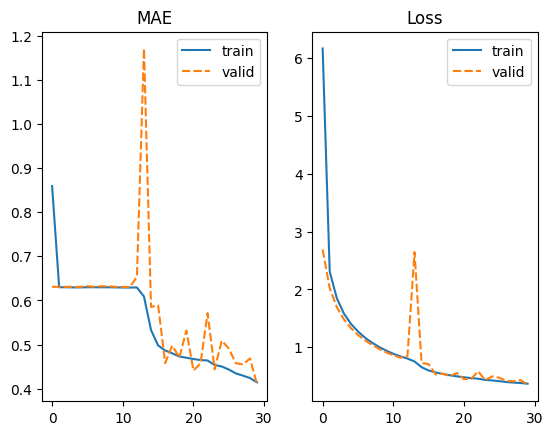

In [5]:
mae_df = pd.DataFrame()
loss_df = pd.DataFrame()
mae_df['train'] = his_model_time_P2_L.history['mae']
mae_df['valid'] = his_model_time_P2_L.history['val_mae']
loss_df['train'] = his_model_time_P2_L.history['loss']
loss_df['valid'] = his_model_time_P2_L.history['val_loss']
fig, axs = plt.subplots(ncols=2)
sns.lineplot(mae_df,ax=axs[0]).set_title("MAE")
sns.lineplot(loss_df,ax=axs[1]).set_title("Loss")
model_time_P2_L.evaluate(test_tx_L,  test_ty_period_L, verbose=2)
# print(test_ty[0:10])
pred_y_P2_L = model_time_P2_L.predict(test_tx_L)
pred_P2_L = period_to_clk(pred_y_P2_L)
print(test_ty_L[:3],pred_P2_L[:3])
np.mean(common_sense_err2(test_ty_L,pred_P2_L),axis = 0)

In [12]:
print(np.mean(common_sense_err2(test_ty_L[10:20],pred_P2_L[10:20]),axis = 0))
test_ty_L[10:20],pred_P2_L[10:20]

[ 0.7 39.9]


(array([[11, 25],
        [10, 15],
        [ 7, 46],
        [ 5,  1],
        [ 1, 44],
        [ 6, 56],
        [ 4, 15],
        [ 3, 55],
        [ 3, 18],
        [ 6, 52]]),
 array([[12., 53.],
        [10., 14.],
        [ 8., 44.],
        [ 4., 19.],
        [11., 55.],
        [ 9., 55.],
        [ 3., 21.],
        [ 2.,  4.],
        [ 2., 10.],
        [ 8., 41.]]))